In [1]:
import os
from collections import defaultdict
import torch
import numpy as np
import scipy.stats
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

smoke_test = ('CI' in os.environ)
pyro.enable_validation(True)

In [2]:
data = torch.tensor([0., 1., 10., 11., 12.])

## Training a MAP estimator

In [3]:
K = 2

@config_enumerate
def model(data):
    # Global variables
    # Categorical分布のパラメータの事前分布． PRML式(10.39)
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    # GMMならガウス-ウィシャート分布ではないのか？PRML式(10.40)のΛ．　 つまりウィシャート分布．
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))
        
    with pyro.plate('data', len(data)):
        # Local variables
        # PRML式(10.37)
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        # PRML式(10.38)
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

In [4]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [5]:
# クラスタの平均の初期値を決める．これは繊細な問題でどこに初期値を取るかが割と重要．
def init_loc_fn(site):
    if site["name"] == "weights":
        return torch.ones(K) / K
    if site["name"] == "scale":
        return (data.var() / 2).sqrt()
    if site["name"] == "locs":
        return data[torch.multinomial(torch.ones(len(data)) / len(data), K)]
    raise ValueError(site["name"])

def initialize(seed):
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']),
                                                  init_loc_fn=init_loc_fn)
    svi = SVI(model, global_guide, optim, loss=elbo)
    return svi.loss(model, global_guide, data)

# 100個のランダムな初期値から最も良いseedを選ぶ
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 7, initial_loss = 25.665584564208984


In [6]:
# During training, we’ll collect both losses and gradient norms to monitor
gradient_norms  = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name,: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if  i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

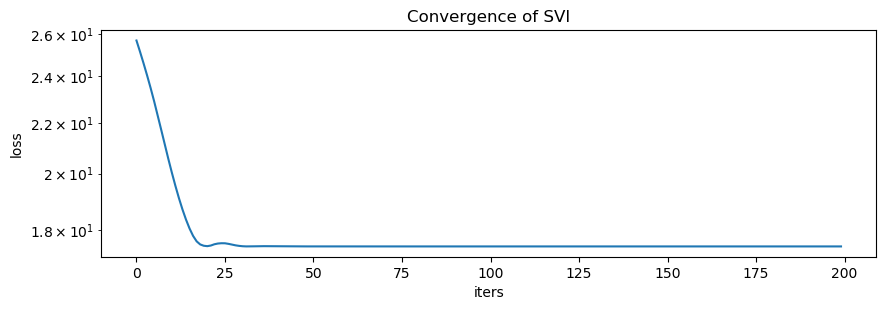

In [7]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

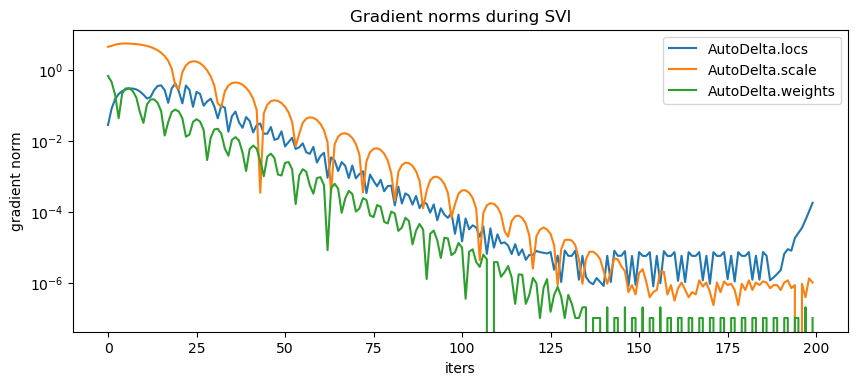

In [8]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [9]:
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']
print('weights = {}'.format(weights.data.numpy()))
print('locs = {}'.format(locs.data.numpy()))
print('scale = {}'.format(scale.data.numpy()))

weights = [0.37500003 0.62499994]
locs = [ 0.49887404 10.984463  ]
scale = 0.6514337062835693


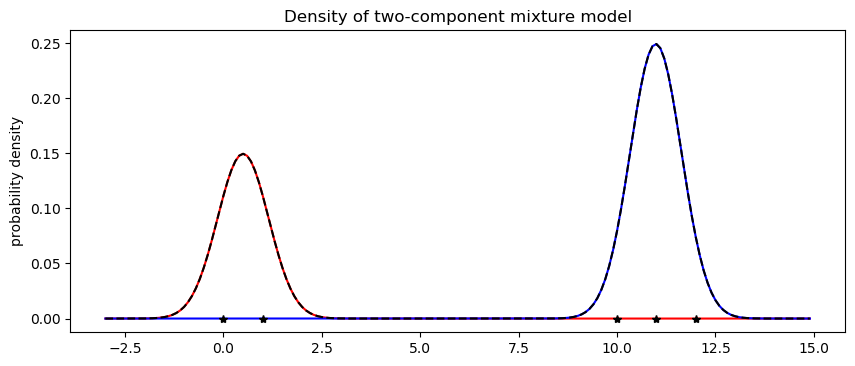

In [10]:
X = np.arange(-3,15,0.1)
Y1 = weights[0].item() * scipy.stats.norm.pdf((X - locs[0].item()) / scale.item())
Y2 = weights[1].item() * scipy.stats.norm.pdf((X - locs[1].item()) / scale.item())

pyplot.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
pyplot.plot(X, Y1, 'r-')
pyplot.plot(X, Y2, 'b-')
pyplot.plot(X, Y1 + Y2, 'k--')
pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
pyplot.title('Density of two-component mixture model')
pyplot.ylabel('probability density');

## Predicting membership

### Using descrete inference

In [12]:
guide_trace = poutine.trace(global_guide).get_trace(data)
trained_model = poutine.replay(model, trace=guide_trace)

def classifier(data, temperature=0):
    inferred_model = infer_discrete(trained_model, temperature=temperature,
                                                             first_available_dim=-2)
    trace = poutine.trace(inferred_model).get_trace(data)
    return trace.nodes["assignment"]["value"]

print(classifier(data))

tensor([0, 0, 1, 1, 1])


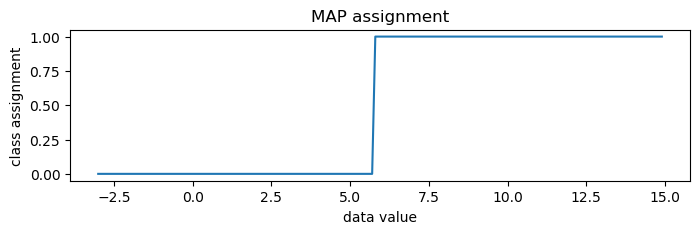

In [13]:
new_data = torch.arange(-3, 15, 0.1)
assignment = classifier(new_data)
pyplot.figure(figsize=(8, 2), dpi=100).set_facecolor('white')
pyplot.plot(new_data.numpy(), assignment.numpy())
pyplot.title('MAP assignment')
pyplot.xlabel('data value')
pyplot.ylabel('class assignment');

In [15]:
# temperatureの役割がよくわからない
print(classifier(data, temperature=1))

tensor([0, 0, 1, 1, 1])


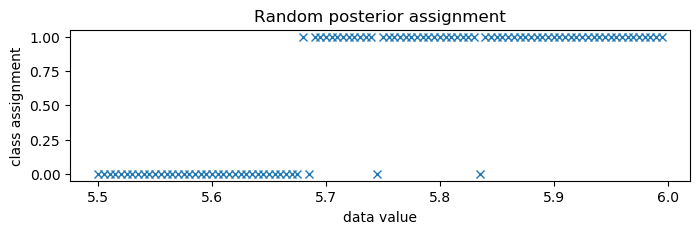

In [16]:
new_data = torch.arange(5.5, 6.0, 0.005)
assignment = classifier(new_data, temperature=1)
pyplot.figure(figsize=(8, 2), dpi=100).set_facecolor('white')
pyplot.plot(new_data.numpy(), assignment.numpy(), 'bx', color='C0')
pyplot.title('Random posterior assignment')
pyplot.xlabel('data value')
pyplot.ylabel('class assignment');

### Enumerating in the guide

In [18]:
@config_enumerate
def full_guide(data):
    # Global variables.
    with poutine.block(hide_types=["param"]):  # Keep our learned values of global parameters.
        global_guide(data)

    # Local variables.
    with pyro.plate('data', len(data)):
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data), K) / K,
                                      constraint=constraints.unit_interval)
        pyro.sample('assignment', dist.Categorical(assignment_probs))

In [19]:
optim = pyro.optim.Adam({'lr': 0.2, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, full_guide, optim, loss=elbo)

# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
svi.loss(model, full_guide, data)  # Initializes param store.
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

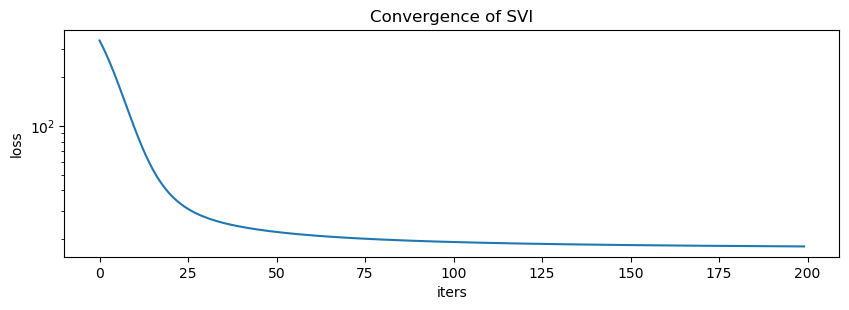

In [20]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

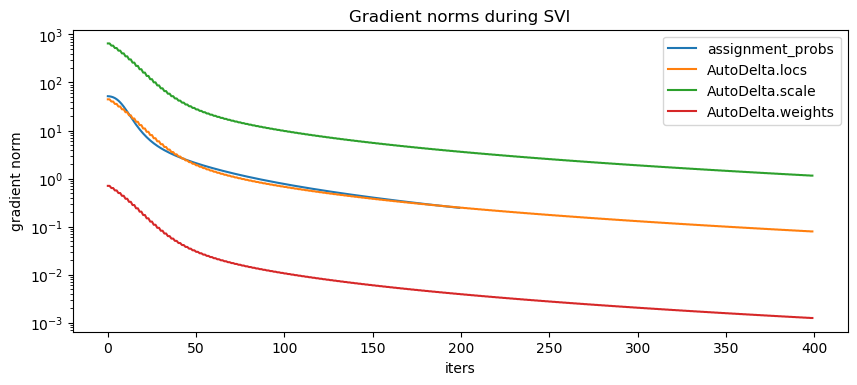

In [21]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

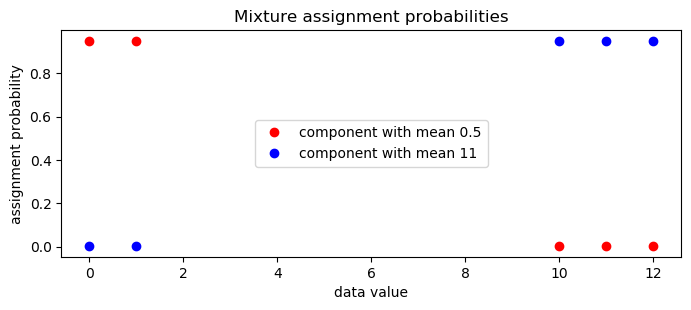

In [22]:
assignment_probs = pyro.param('assignment_probs')
pyplot.figure(figsize=(8, 3), dpi=100).set_facecolor('white')
pyplot.plot(data.data.numpy(), assignment_probs.data.numpy()[:, 0], 'ro',
            label='component with mean {:0.2g}'.format(locs[0]))
pyplot.plot(data.data.numpy(), assignment_probs.data.numpy()[:, 1], 'bo',
            label='component with mean {:0.2g}'.format(locs[1]))
pyplot.title('Mixture assignment probabilities')
pyplot.xlabel('data value')
pyplot.ylabel('assignment probability')
pyplot.legend(loc='center');

## MCMC

In [23]:
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
pyro.set_rng_seed(2)
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=250, warmup_steps=50)
mcmc.run(data)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 300/300 [00:12, 23.90it/s, step size=8.10e-01, acc. prob=0.747]


In [24]:
X, Y = posterior_samples["locs"].t()

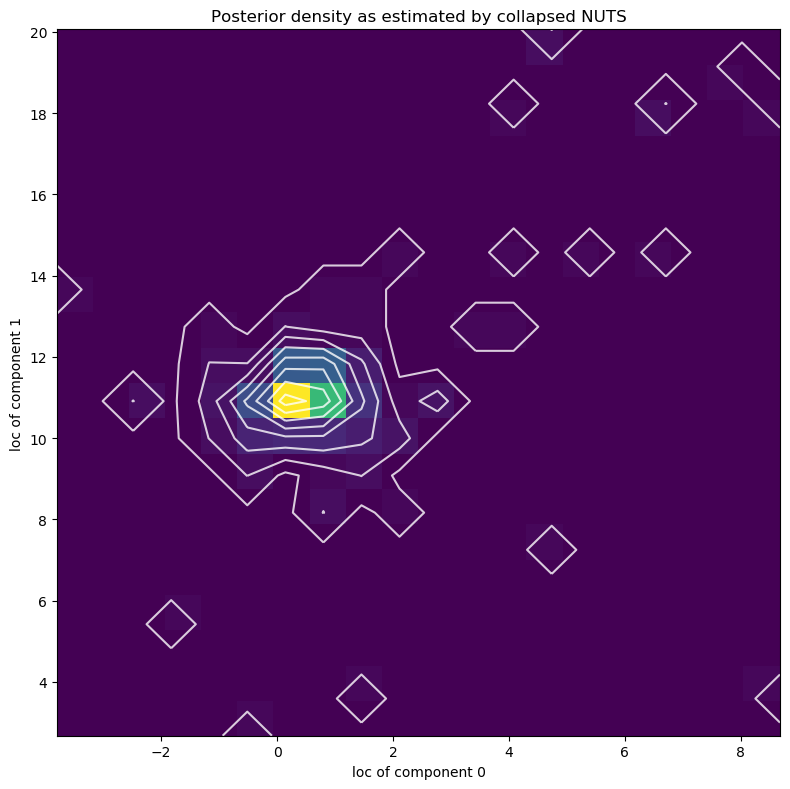

In [25]:
pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
h, xs, ys, image = pyplot.hist2d(X.numpy(), Y.numpy(), bins=[20, 20])
pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
               colors='white', alpha=0.8)
pyplot.title('Posterior density as estimated by collapsed NUTS')
pyplot.xlabel('loc of component 0')
pyplot.ylabel('loc of component 1')
pyplot.tight_layout()

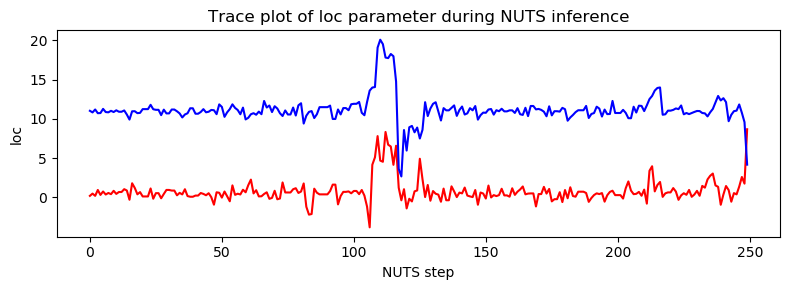

In [26]:
pyplot.figure(figsize=(8, 3), dpi=100).set_facecolor('white')
pyplot.plot(X.numpy(), color='red')
pyplot.plot(Y.numpy(), color='blue')
pyplot.xlabel('NUTS step')
pyplot.ylabel('loc')
pyplot.title('Trace plot of loc parameter during NUTS inference')
pyplot.tight_layout()